# Toy Example for Diffusion

This notebook demonstrates how to train a diffusion model on toy 2D spiral datasets using the SciREX library.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import nnx as nn

from scirex.data import LabeledTransform, create_dataloader
from scirex.diffusion import diffusion_loss, get_sigma_embeds, sample_ddim, sample_ddpm
from scirex.training import Trainer

# Set up plotting style
plt.style.use("seaborn-v0_8-muted")
%matplotlib inline

# Part 1: 2D Spiral Diffusion

## 1. Data Generation

We create a 2D spiral dataset and normalize it.

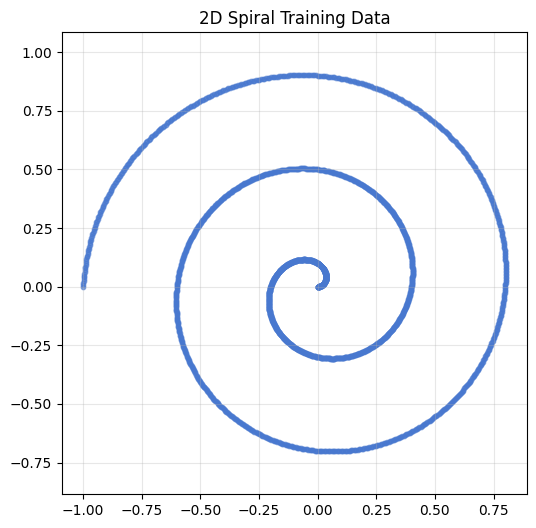

In [2]:
def create_spiral_data(tmin=0, tmax=5 * jnp.pi, n_points: int = 100) -> jnp.ndarray:
    t = jnp.linspace(tmin, tmax, n_points)
    x = t * jnp.cos(t) / tmax
    y = t * jnp.sin(t) / tmax
    data = jnp.stack([x, y], axis=1)
    # Normalize to [-1, 1]
    data = data / jnp.abs(data).max()
    return data


train_data_2d = create_spiral_data(n_points=2000)
plt.figure(figsize=(6, 6))
plt.scatter(train_data_2d[:, 0], train_data_2d[:, 1], alpha=0.6, s=10)
plt.title("2D Spiral Training Data")
plt.axis("equal")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Model Architecture

We define a simple `TimeInputMLP` that takes data and noise levels as input.

In [3]:
class TimeInputMLP(nn.Module):
    def __init__(self, in_size: int, out_size: int, hidden_size: int, rngs: nn.Rngs):
        self.mlp = nn.Sequential(
            nn.Linear(in_size + 2, hidden_size, rngs=rngs),
            nn.relu,
            nn.Linear(hidden_size, hidden_size, rngs=rngs),
            nn.relu,
            nn.Linear(hidden_size, out_size, rngs=rngs),
        )

    def __call__(self, x, sigma):
        sigma_embed = get_sigma_embeds(sigma)
        if x.ndim == 1:
            x = x[None, :]
        if sigma_embed.ndim == 1:
            sigma_embed = sigma_embed[None, :]
        if sigma_embed.shape[0] != x.shape[0]:
            sigma_embed = jnp.broadcast_to(sigma_embed, (x.shape[0], sigma_embed.shape[1]))

        x_input = jnp.concatenate([x, sigma_embed], axis=-1)
        return self.mlp(x_input)

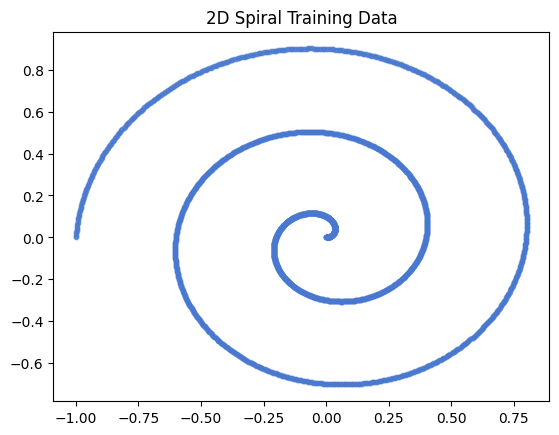

In [4]:
# Create 2D spiral training data
train_data_2d = create_spiral_data(n_points=2000)
plt.scatter(train_data_2d[:, 0], train_data_2d[:, 1], alpha=0.6, s=10)
plt.title("2D Spiral Training Data")
plt.show()

In [5]:
# Create diffusion model for 2D data
model_2d = TimeInputMLP(in_size=2, out_size=2, hidden_size=128, rngs=nn.Rngs(0))

In [6]:
# Create trainer for 2D spiral diffusion model
from scirex.diffusion import ScheduleCosine

schedule = ScheduleCosine(N=1000)
optimizer = nn.Optimizer(model_2d, optax.adam(1e-3))

trainer = Trainer(model=model_2d, optimizer=optimizer, loss_fn=diffusion_loss(schedule), rngs=nn.Rngs(0))

## 3. Training and Sampling

We train the model and sample from it.

In [7]:
train_loader = create_dataloader(
    np.array(train_data_2d),
    batch_size=128,
    shuffle=True,
    seed=0,
)

In [8]:
# Train the diffusion model
trainer.train(train_loader=train_loader, n_epochs=100)

2026-02-13 06:28:54.888 | INFO     | scirex.training.trainer:train:212 - Starting training for 100 epochs
ERROR:absl:Error occurred in child process with worker_index: 1
Traceback (most recent call last):
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/grain_pool.py", line 262, in _worker_loop
    next_element = next(element_producer)
                   ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/dataset/transformations/prefetch.py", line 567, in __call__
    it = self._ds.__iter__()
         ^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/dataset/dataset.py", line 1628, in __iter__
    result = self._parent.__iter__()
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/dataset/transformations/map.py", line 432, in __iter_

TypeError: Grain worker 0 failed with the following error:

Traceback (most recent call last):
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/grain_pool.py", line 262, in _worker_loop
    next_element = next(element_producer)
                   ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/dataset/transformations/prefetch.py", line 567, in __call__
    it = self._ds.__iter__()
         ^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/dataset/dataset.py", line 1628, in __iter__
    result = self._parent.__iter__()
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/dataset/transformations/map.py", line 432, in __iter__
    self._parent.__iter__(),
    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/data_loader.py", line 187, in __iter__
    return _OperationDatasetIterator(self._parent.__iter__(), self.operation)
                                     ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/data_loader.py", line 187, in __iter__
    return _OperationDatasetIterator(self._parent.__iter__(), self.operation)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lokesh/Projects/iisc/SciREX/.venv/lib/python3.11/site-packages/grain/_src/python/data_loader.py", line 200, in __init__
    self._iterator = operation(parent)
                     ^^^^^^^^^^^^^^^^^
TypeError: 'ArrayTransform' object is not callable


In [ ]:
trainer.visualize()

In [ ]:
# Sampling Part 1

rngs = nn.Rngs(0)
n_samples = 2000
# DDPM Sampling
print("Sampling DDPM...")
samples_ddpm = sample_ddpm(model_2d, schedule.sample_sigmas(20), batchsize=n_samples, shape=(2,), rng=rngs)

# DDIM Sampling
print("Sampling DDIM...")
samples_ddim = sample_ddim(model_2d, schedule.sample_sigmas(20), batchsize=n_samples, shape=(2,), rng=rngs)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Real Data
# Re-fetch or reuse data. Assuming 'train_data_2d' is the variable name from Cell 3.
axes[0].scatter(train_data_2d[:, 0], train_data_2d[:, 1], s=10, alpha=0.6, label="Real Data")
axes[0].set_title("Real Data")
axes[0].axis("equal")
axes[0].legend()

# DDPM Samples
axes[1].scatter(samples_ddpm[:, 0], samples_ddpm[:, 1], s=10, alpha=0.6, color="orange", label="DDPM Samples")
axes[1].set_title("DDPM Samples")
axes[1].axis("equal")
axes[1].legend()

# DDIM Samples
axes[2].scatter(samples_ddim[:, 0], samples_ddim[:, 1], s=10, alpha=0.6, color="green", label="DDIM Samples")
axes[2].set_title("DDIM Samples")
axes[2].axis("equal")
axes[2].legend()

plt.show()

# Part 2: Segmented 2D Spiral with CFG

## 1. Segmented Data Generation

We divide the 2D spiral into segments, each assigned a class index.

In [ ]:
def create_segmented_spiral(tmin=0, tmax=5 * jnp.pi, n_points: int = 100, n_classes: int = 3):
    t = jnp.linspace(tmin, tmax, n_points)
    x = t * jnp.cos(t)
    y = t * jnp.sin(t)
    data = jnp.stack([x, y], axis=1)
    # Normalize to [-1, 1]
    data = data / jnp.abs(data).max()

    labels = (jnp.arange(n_points) * n_classes // n_points).astype(jnp.int32)
    return data, labels


train_data_seg, train_labels_seg = create_segmented_spiral(n_points=100)
plt.figure(figsize=(6, 6))
colors = ["red", "blue", "green"]
for i in range(3):
    mask = train_labels_seg == i
    plt.scatter(train_data_seg[mask, 0], train_data_seg[mask, 1], color=colors[i], s=10, alpha=0.6, label=f"Class {i}")
plt.legend()
plt.title("Segmented 2D Spiral Training Data")
plt.axis("equal")
plt.show()

## 2. Conditional Model Architecture

We define a `ConditionalMLP` incorporating class embeddings.

In [ ]:
class ConditionalMLP(nn.Module):
    def __init__(self, in_size: int, out_size: int, hidden_size: int, num_classes: int, rngs: nn.Rngs):
        self.class_embed = nn.Embed(num_classes, hidden_size, rngs=rngs)
        self.encoding_size = hidden_size
        self.mlp = nn.Sequential(
            nn.Linear(in_size + 2 + hidden_size, hidden_size, rngs=rngs),
            nn.relu,
            nn.Linear(hidden_size, hidden_size, rngs=rngs),
            nn.relu,
            nn.Linear(hidden_size, out_size, rngs=rngs),
        )

    def __call__(self, x, sigma, cond=None):
        sigma_embed = get_sigma_embeds(sigma)
        if x.ndim == 1:
            x = x[None, :]
        if sigma_embed.ndim == 1:
            sigma_embed = sigma_embed[None, :]
        if sigma_embed.shape[0] != x.shape[0]:
            sigma_embed = jnp.broadcast_to(sigma_embed, (x.shape[0], sigma_embed.shape[1]))

        inputs = [x, sigma_embed]
        if cond is not None:
            inputs.append(self.class_embed(cond))
        else:
            inputs.append(jnp.zeros((x.shape[0], self.encoding_size)))

        return self.mlp(jnp.concatenate(inputs, axis=-1))

In [ ]:
# Create segmented spiral training data
train_data_seg, train_labels_seg = create_segmented_spiral(n_points=100)

# Visualize the segmented data
colors = ["purple", "cyan", "yellow"]
for i in range(3):
    mask = train_labels_seg == i
    plt.scatter(train_data_seg[mask, 0], train_data_seg[mask, 1], color=colors[i], s=10, alpha=0.6, label=f"Class {i}")
plt.legend()
plt.title("Segmented Spiral Training Data")
plt.show()

In [ ]:
# Create conditional diffusion model
model_cond = ConditionalMLP(in_size=2, out_size=2, hidden_size=128, num_classes=3, rngs=nn.Rngs(0))

In [ ]:
# Create trainer for conditional diffusion model
schedule_cond = ScheduleCosine(N=1000)
optimizer_cond = nn.Optimizer(model_cond, optax.adam(1e-3))

trainer_cond = Trainer(
    model=model_cond, optimizer=optimizer_cond, loss_fn=diffusion_loss(schedule_cond), rngs=nn.Rngs(0)
)

## 3. Training and CFG Sampling

We train and demonstrate conditional sampling using CFG.

In [ ]:
# Create dataloader for segmented spiral data
train_loader_seg = create_dataloader(
    np.array(train_data_seg),
    batch_size=128,
    shuffle=True,
    seed=0,
    labels=np.array(train_labels_seg),
    custom_operations=[LabeledTransform(np.array(train_data_seg), np.array(train_labels_seg))],
)

In [ ]:
# Train the conditional diffusion model
trainer_cond.train(train_loader=train_loader_seg, n_epochs=100)

In [ ]:
trainer_cond.visualize()

In [ ]:
# Sampling Part 2
n_per_class = 500
classes = [0, 1, 2]
# Ensure colors are available
colors = ["purple", "cyan", "yellow"]
rngs = nn.Rngs(0)

print("Sampling Part 2...")

# 1. Real Data
# Assuming train_data_seg and train_labels_seg are available
train_data_np = np.array(train_data_seg)
train_labels_np = np.array(train_labels_seg)

# 2. DDPM (Conditional, NO guidance)
print("Sampling DDPM (Conditional)...")
samples_ddpm_cond = []
for c in classes:
    cond = jnp.full((n_per_class,), c)
    # uncond=None, guidance_scale=None -> Standard conditional
    s = sample_ddpm(
        model_cond,
        schedule.sample_sigmas(20),
        batchsize=n_per_class,
        shape=(2,),
        cond=cond,
        uncond=None,
        guidance_scale=None,
        rng=rngs,
    )
    samples_ddpm_cond.append(s)

# 3. DDIM (Conditional, NO guidance)
print("Sampling DDIM (Conditional)...")
samples_ddim_cond = []
for c in classes:
    cond = jnp.full((n_per_class,), c)
    s = sample_ddim(
        model_cond,
        schedule.sample_sigmas(20),
        batchsize=n_per_class,
        shape=(2,),
        cond=cond,
        uncond=None,
        guidance_scale=None,
        rng=rngs,
    )
    samples_ddim_cond.append(s)

# 4. CFG (Guidance scale = 5.0)
print("Sampling CFG (Scale=5.0)...")
samples_cfg = []
scale = 5.0
for c in classes:
    cond = jnp.full((n_per_class,), c)
    # guidance_scale=5.0, uncond=None.
    # With updated reverse.py, this will use None as uncond condition (zeros in model).
    s = sample_ddim(
        model_cond,
        schedule.sample_sigmas(20),
        batchsize=n_per_class,
        shape=(2,),
        cond=cond,
        uncond=None,
        guidance_scale=scale,
        rng=rngs,
    )
    samples_cfg.append(s)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Real Data
for i, c in enumerate(classes):
    idx = train_labels_np == c
    axes[0].scatter(train_data_np[idx, 0], train_data_np[idx, 1], s=10, alpha=0.6, color=colors[i], label=f"Class {c}")
axes[0].set_title("Real Data")
axes[0].axis("equal")
axes[0].legend()

# DDPM
for i, s in enumerate(samples_ddpm_cond):
    axes[1].scatter(s[:, 0], s[:, 1], s=10, alpha=0.6, color=colors[i], label=f"Class {i}")
axes[1].set_title("DDPM (Cond)")
axes[1].axis("equal")
axes[1].legend()

# DDIM
for i, s in enumerate(samples_ddim_cond):
    axes[2].scatter(s[:, 0], s[:, 1], s=10, alpha=0.6, color=colors[i], label=f"Class {i}")
axes[2].set_title("DDIM (Cond)")
axes[2].axis("equal")
axes[2].legend()

# CFG
for i, s in enumerate(samples_cfg):
    axes[3].scatter(s[:, 0], s[:, 1], s=10, alpha=0.6, color=colors[i], label=f"Class {i}")
axes[3].set_title(f"CFG (Scale={scale})")
axes[3].axis("equal")
axes[3].legend()

plt.show()